# Supplementary Figure S2

### Setups

In [1]:
library(dplyr)
library(ggplot2)
library(ggpubr)
library(ggsci)
library(patchwork)
library(aplot)
library(ggrastr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Functions 

In [2]:
set.seed(7)

In [3]:
plot_confounder_embedding<-function(anot.embed,...){
    
    col.pal <- colorRampPalette(colors = c( "#115f9a", "#1984c5", "#22a7f0", "#48b5c4", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"))
    
    colnames(anot.embed)<-gsub("_.*","",colnames(anot.embed))
    
    p1<-anot.embed %>%
        ggplot(.,aes(x=PC1,y=PC2,color=impurity))+
        rasterise(geom_point(size=1.25,na.rm=TRUE),dpi=300)+
        theme_pubr()+
        scale_color_gradientn(colours = col.pal(10))+
        theme(legend.position="right")
    
    p2<-anot.embed %>%
        ggplot(.,aes(x=PC1,y=PC3,color=impurity))+
        rasterise(geom_point(size=1.25,na.rm=TRUE),dpi=300)+
            theme_pubr()+
            scale_color_gradientn(colours = col.pal(10))+
            theme(legend.position="right")
    
    return(list(p1,p2))
}

### Load data

In [4]:
load("../input/tcga.metadata.RData")
load("../input/tcga.SE.splicing.embeddings.RData")
load("../input/tcga.gene.expression.embeddings.RData")

In [5]:
tcga.colors<-c("#EF9A9A","#F8BBD0","#CE93D8","#B39DDB","#9FA8DA",
               "#90CAF9","#81D4FA","#80DEEA","#80CBC4","#A5D6A7",
               "#C5E1A5","#E6EE9C","#FFF59D","#FFE082","#BCAAA4",
               "#F44336","#E91E63","#9C27B0","#673AB7","#3F51B5",
               "#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50",
               "#8BC34A","#CDDC39","#FFC107","#FF9800","#795548",
               "#B71C1C")
names(tcga.colors)<-unique(metadata$cancer)

### Expression PCs

In [6]:
gem<-left_join(metadata,gene_embed,by = "submitter_id") 

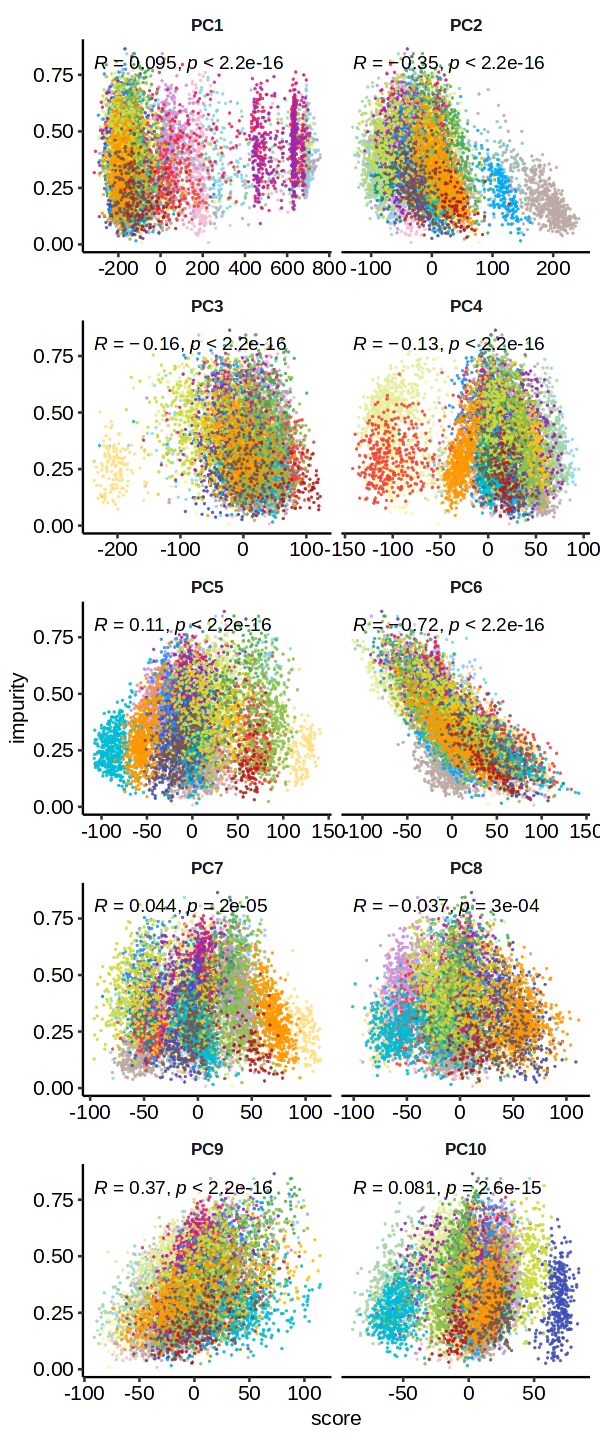

In [7]:
options(repr.plot.height=12,repr.plot.width=5)
gem.lng<-gem %>%
         filter(impurity!=0) %>%
         select(PC1_exp:PC10_exp,impurity,cancer) %>% 
         tidyr::pivot_longer(cols = PC1_exp:PC10_exp,names_to = "PC",values_to = "score") %>%
         mutate(PC=sub("_exp","",PC))%>%
         mutate(PC=factor(PC,levels=paste0("PC",1:10)))
p<-gem.lng %>%
    ggplot(.,aes(x=score,y=impurity))+
        rasterise(geom_point(aes(color=cancer),alpha=0.75,size=0.1),dpi=300)+
        facet_wrap(~PC,ncol = 2,scales = "free_x")+
        theme_pubr()+
        theme(legend.position="none",
              strip.background=element_blank(),
              strip.text=element_text(face="bold"))+
        stat_cor()+
        scale_color_manual(values=tcga.colors)
p

In [8]:
ggsave(p,filename="../output/embeddings/global/tcga.gex.PCs.vs.impurity.pdf",device="pdf",height = 12,width=5,units="in")

### Splicing PCs

In [9]:
splem<-left_join(metadata,spl_embed,by = "submitter_id") 

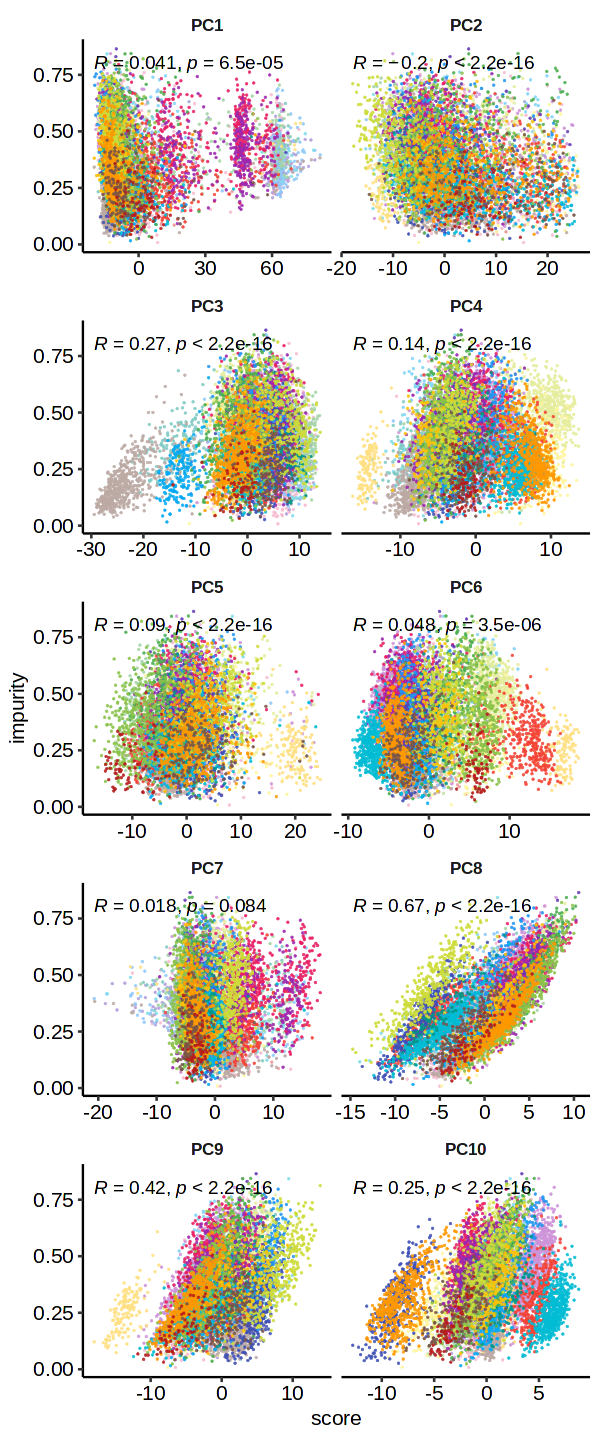

In [10]:
options(repr.plot.height=12,repr.plot.width=5)
spl.lng<-splem %>%
         filter(impurity!=0) %>%
         select(PC1_spl:PC10_spl,impurity,cancer) %>% 
         tidyr::pivot_longer(cols = PC1_spl:PC10_spl,names_to = "PC",values_to = "score") %>%
         mutate(PC=factor(sub("_spl","",PC),levels = paste0("PC",1:10)))

p<-spl.lng %>%
    ggplot(.,aes(x=score,y=impurity))+
        rasterise(geom_point(aes(color=cancer),alpha=0.75,size=0.1),dpi=300)+
        facet_wrap(~PC,ncol = 2,scales = "free_x")+
        theme_pubr()+
        theme(legend.position="none",
              strip.background=element_blank(),
              strip.text=element_text(face="bold"))+
        stat_cor()+
        scale_color_manual(values=tcga.colors)
p

In [11]:
ggsave(p,filename="../output/embeddings/global/tcga.spl.PCs.vs.impurity.pdf",device="pdf",height = 12,width=5,units="in")

### Median impurity vs total variance explained by impurity-correlated PCs 

In [12]:
pca.var.cor<-readRDS("../input/pc.impurity.correlations.RDS")

In [13]:
cord<-metadata %>% 
        filter(condition=="tumor") %>% 
        group_by(cancer) %>% 
        summarize(median_imp=median(impurity,na.rm=T),
                  mean_imp=mean(impurity,na.rm=T),
                  var_imp=var(impurity),
                  sd_imp=sd(impurity)) %>% 
        arrange(desc(median_imp))
colors.cord<-tcga.colors[cord$cancer]

In [14]:
stats<-pca.var.cor %>%
        filter(significant) %>%
        group_by(cancer,mode) %>%
        summarize(tot_var=sum(Pvar),
                  npcs=length(Pvar)) %>%
        ungroup() %>%
        left_join(.,cord,by = "cancer") %>% 
        na.omit() 

`summarise()` has grouped output by 'cancer'. You can override using the
`.groups` argument.


In [15]:
stats.e<-stats %>% filter(mode=="expression")
et<-cor.test(stats.e$tot_var,stats.e$median_imp,method = "spearman")

stats.s<-stats %>% filter(mode=="splicing")
st<-cor.test(stats.s$tot_var,stats.s$median_imp,method = "spearman")

stats.df<-data.frame(mode=c("expression","splicing"),
                     rho=paste("rho =",c(round(et$estimate,4),round(st$estimate,4))),
                     plab=paste("p =",c(round(et$p.value,6),round(st$p.value,6))))

Warning message in cor.test.default(stats.e$tot_var, stats.e$median_imp, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(stats.s$tot_var, stats.s$median_imp, method = "spearman"):
“Cannot compute exact p-value with ties”


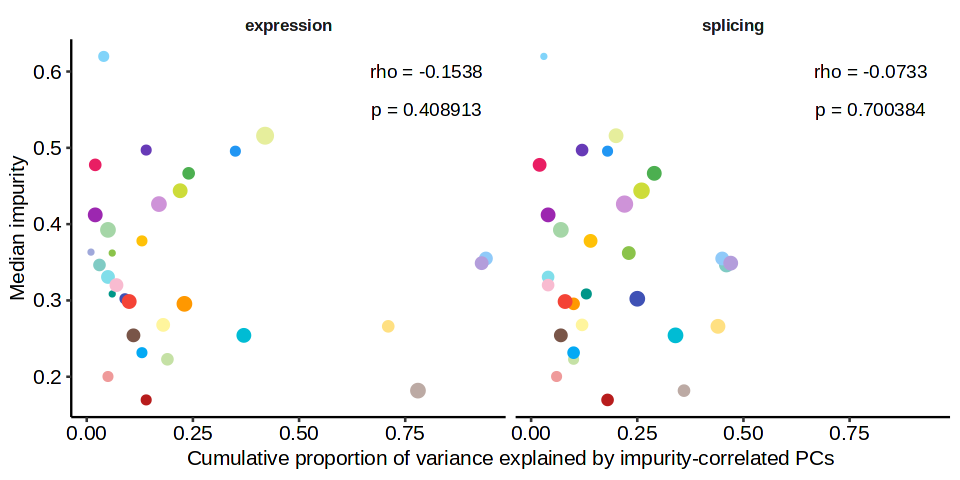

In [16]:
options(repr.plot.height=4,repr.plot.width=8)

g<-ggplot(stats,aes(x=tot_var,y=median_imp,color=cancer))+
    geom_point(aes(size=npcs))+
    theme_pubr()+
    scale_color_manual(values=colors.cord,guide="none")+
    theme(legend.position="none",
          strip.background=element_blank(),
          strip.text=element_text(face="bold"))+
    facet_wrap(~mode)+
    labs(x="Cumulative proportion of variance explained by impurity-correlated PCs",
         y="Median impurity",
         size="Number of\nsignificant\nPCs")+
    scale_size_continuous(limits = c(1,9),breaks = c(1,3,6,9),range = c(1,4))+
    geom_text(x = 0.8, y = 0.6, aes(label = rho), data = stats.df,inherit.aes = F)+
    geom_text(x = 0.8, y = 0.55, aes(label = plab), data = stats.df,inherit.aes = F)
g

In [17]:
et
st


	Spearman's rank correlation rho

data:  stats.e$tot_var and stats.e$median_imp
S = 5722.6, p-value = 0.4089
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1537531 



	Spearman's rank correlation rho

data:  stats.s$tot_var and stats.s$median_imp
S = 4824.4, p-value = 0.7004
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.07327399 


In [18]:
ggsave(g,filename= "../output/impurity/tcga.PCvariance.vs.MedianImpurity.pdf",device="pdf",width=8,height=2,units="in")
ggsave(g,filename= "../output/impurity/tcga.PCvariance.vs.MedianImpurity.png",device="png",width=8,height=2,units="in", dpi=1000)